In [1]:
!pip install torch torchvision matplotlib


```python
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
```
*   **`torch`**: The main PyTorch library.
*   **`nn`**: Contains building blocks for neural networks (Layers like `Conv2d`, `Linear`).
*   **`F`**: Contains functions that don't have parameters (like `relu`, `mse_loss`).
*   **`optim`**: Contains optimization algorithms (like `Adam`).
*   **`datasets`, `transforms`**: Helpers to download CIFAR-10 and manipulate images (resize, normalize).
*   **`DataLoader`**: A utility that helps us feed data into the model in "batches" (chunks) instead of all at once.
*   **`matplotlib`**: Used to draw the images at the end.

---

### **Block 2: The Vector Quantizer (The Brain)**
This is the class that performs the "Snap to Grid" operation.

```python
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
```
*   **`class ...`**: We define a custom PyTorch module.
*   **`num_embeddings`**: How many words are in our dictionary? (e.g., 512).
*   **`embedding_dim`**: How long is each word vector? (e.g., 64 numbers).
*   **`commitment_cost`**: The $\beta$ hyperparameter. How strongly do we force the encoder to stick to the codebook?

```python
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
```
*   **`nn.Embedding`**: This creates the **Codebook**. It is a lookup table matrix of size [512, 64].
*   **`.uniform_`**: We initialize the codebook with small random numbers. If we started with Zeros, the math wouldn't work (gradients would die).

```python
    def forward(self, inputs):
        input_shape = inputs.shape
```
*   **`inputs`**: The output from the Encoder. Shape is `[Batch, 64, 8, 8]` (Batch, Channel, Height, Width).
*   **`input_shape`**: We save the original shape so we can restore it later.

```python
        flat_input = inputs.permute(0, 2, 3, 1).contiguous()
        flat_input = flat_input.view(-1, self._embedding_dim)
```
*   **`.permute(0, 2, 3, 1)`**: PyTorch stores images as `[Channel, Height, Width]`. To do math on vectors, we need the Channel at the end: `[Height, Width, Channel]`.
*   **`.contiguous()`**: Permuting shuffles pointers in memory. This command physically rearranges the data in memory so it's safe to reshape.
*   **`.view(-1, ...)`**: We flatten the batch and spatial dimensions. We turn a grid of images into one massive list of pixels (vectors). Shape becomes `[Batch*8*8, 64]`.

```python
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
```
*   **`distances`**: This calculates the Euclidean distance between *every* input pixel and *every* codebook vector.
*   **The Math**: instead of doing `(a-b)^2` which is slow, it uses the expansion `a^2 + b^2 - 2ab`.
    *   `flat_input**2`: $a^2$
    *   `weight**2`: $b^2$
    *   `matmul`: $ab$ (Dot product).

```python
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
```
*   **`argmin`**: "Argument Minimum". It looks at the distances and says: "For pixel #1, Codebook vector #42 is the closest." It returns the index `42`.

```python
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
```
*   **One-Hot Encoding**: We turn the index `42` into a vector of 512 zeros, with a `1` at position 42.

```python
        quantized = torch.matmul(encodings, self._embedding.weight)
```
*   **`matmul`**: We multiply the One-Hot vector by the Codebook matrix. This retrieves the actual vector `[-0.5, 0.2, ...]` corresponding to index 42.

```python
        quantized = quantized.view(input_shape[0], input_shape[2], input_shape[3], input_shape[1])
        quantized = quantized.permute(0, 3, 1, 2).contiguous()
```
*   **`view`**: We reshape the long list back into a square grid: `[Batch, Height, Width, Channels]`.
*   **`permute`**: We swap the Channel back to the PyTorch standard: `[Batch, Channels, Height, Width]`.
*   *Note: This is where the fix was applied to prevent the shape mismatch error.*

```python
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
```
*   **`inputs.detach()`**: "Don't update the Encoder for this calculation." (Calculates Codebook Loss).
*   **`quantized.detach()`**: "Don't update the Codebook for this calculation." (Calculates Commitment Loss).
*   **`loss`**: We combine them to get the VQ loss.

```python
        quantized = inputs + (quantized - inputs).detach()
```
*   **The Straight-Through Estimator**:
    *   Forward pass: `inputs` cancels out. Result is `quantized`.
    *   Backward pass: `detach` blocks gradients on the parenthesis. Result is `inputs`.
    *   This tricks PyTorch into copying gradients from Decoder $\to$ Encoder, skipping the non-differentiable `argmin`.

---

### **Block 3: Encoder & Decoder**
Standard Convolutional Neural Networks (CNNs).

```python
class Encoder(nn.Module):
    ...
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels, hidden_dims, 4, 2, 1),
```
*   **`Conv2d(..., 4, 2, 1)`**:
    *   Kernel size 4.
    *   **Stride 2**: This cuts the image size in half (Downsampling).
    *   **Padding 1**: Keeps borders valid.
    *   This compresses 32x32 $\to$ 16x16.

```python
        nn.Conv2d(hidden_dims, embedding_dim, 3, 1, 1)
```
*   The final layer squashes the "Channels" (features) down to 64 (`embedding_dim`), which matches our codebook vector size.

```python
class Decoder(nn.Module):
    ...
    nn.ConvTranspose2d(embedding_dim, hidden_dims, 4, 2, 1),
```
*   **`ConvTranspose2d`**: The opposite of Convolution. It takes a small image and expands it (Upsampling).
*   Stride 2 doubles the size: 16x16 $\to$ 32x32.

---

### **Block 4: The Wrapper (VQVAE)**

```python
class VQVAE(nn.Module):
    ...
    def forward(self, x):
        z = self.encoder(x)         # 1. Compress image
        loss, quantized, _ = self.vq_layer(z) # 2. Snap to grid (Quantize)
        x_recon = self.decoder(quantized)     # 3. Reconstruct image
        return loss, x_recon
```
*   This simply ties the three parts together.

---

### **Block 5: Settings & Data**

```python
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
```
*   **`ToTensor`**: Converts the image from a Python Image object (0-255) to a PyTorch Tensor (0.0-1.0).
*   **`Normalize`**: (Value - 0.5) / 0.5. This shifts the data range from `[0, 1]` to `[-1, 1]`. Neural networks learn better when data is centered around 0.

---

### **Block 6: The Training Loop**

```python
for epoch in range(NUM_EPOCHS):
    for batch_idx, (data, _) in enumerate(train_loader):
```
*   We loop through the dataset 50 times (`NUM_EPOCHS`).
*   `data` is a batch of 256 images. `_` ignores the labels (we don't care if it's a cat or dog, we just want to draw it).

```python
        vq_loss, data_recon = model(data)
```
*   Pass data through the model. Get the reconstruction and the VQ-specific loss (commitment + codebook).

```python
        recon_loss = F.mse_loss(data_recon, data)
```
*   Calculate how different the output image is from the input image.

```python
        loss = recon_loss + vq_loss
```
*   Add the errors together. The model must minimize *both*: Look like the original image AND use the codebook properly.

```python
        loss.backward()
        optimizer.step()
```
*   **`backward()`**: Calculate gradients (Calculus/Chain rule).
*   **`step()`**: Update the weights of the network to reduce error.

---

### **Block 7: Visualization**

```python
    test_images = test_images.cpu()
    reconstructions = reconstructions.cpu()
```
*   Matplotlib (the plotting library) runs on the CPU. We must move data from GPU RAM to System RAM.

```python
    def unnorm(img): return img * 0.5 + 0.5
```
*   The model outputs data between -1 and 1.
*   To display it as an image, we need to shift it back to 0 to 1.

```python
    plt.imshow(unnorm(test_images[i]).permute(1, 2, 0))
```
*   **`.permute(1, 2, 0)`**:
    *   PyTorch format: `[Channel, Height, Width]` (e.g., 3, 32, 32).
    *   Matplotlib format: `[Height, Width, Channel]` (e.g., 32, 32, 3).
    *   We must swap the axes to display the image correctly.

Using device: cuda
Starting Training...
Epoch 1/50 | Loss: 8.7829
Epoch 2/50 | Loss: 0.4747
Epoch 3/50 | Loss: 0.1431
Epoch 4/50 | Loss: 0.1091
Epoch 5/50 | Loss: 0.1079
Epoch 6/50 | Loss: 0.1092
Epoch 7/50 | Loss: 0.1076
Epoch 8/50 | Loss: 0.1059
Epoch 9/50 | Loss: 0.1066
Epoch 10/50 | Loss: 0.1078
Epoch 11/50 | Loss: 0.1084
Epoch 12/50 | Loss: 0.1081
Epoch 13/50 | Loss: 0.1080
Epoch 14/50 | Loss: 0.1097
Epoch 15/50 | Loss: 0.1113
Epoch 16/50 | Loss: 0.1118
Epoch 17/50 | Loss: 0.1117
Epoch 18/50 | Loss: 0.1117
Epoch 19/50 | Loss: 0.1115
Epoch 20/50 | Loss: 0.1116
Epoch 21/50 | Loss: 0.1113
Epoch 22/50 | Loss: 0.1113
Epoch 23/50 | Loss: 0.1110
Epoch 24/50 | Loss: 0.1105
Epoch 25/50 | Loss: 0.1101
Epoch 26/50 | Loss: 0.1098
Epoch 27/50 | Loss: 0.1097
Epoch 28/50 | Loss: 0.1095
Epoch 29/50 | Loss: 0.1091
Epoch 30/50 | Loss: 0.1089
Epoch 31/50 | Loss: 0.1088
Epoch 32/50 | Loss: 0.1086
Epoch 33/50 | Loss: 0.1089
Epoch 34/50 | Loss: 0.1089
Epoch 35/50 | Loss: 0.1090
Epoch 36/50 | Loss: 0.10

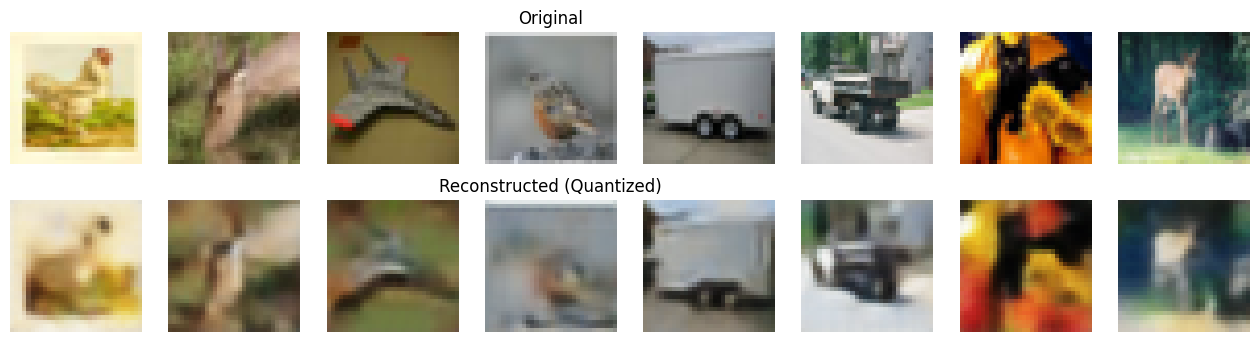

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ==========================================
# 1. THE VECTOR QUANTIZER (The Heart of VQ-VAE)
# ==========================================
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # inputs shape: [Batch, Channels, Height, Width]
        # Example: [256, 64, 8, 8]
        input_shape = inputs.shape

        # Flatten: [Batch, Height, Width, Channels] -> [Batch * Height * Width, Channels]
        flat_input = inputs.permute(0, 2, 3, 1).contiguous()
        flat_input = flat_input.view(-1, self._embedding_dim)

        # Calculate Distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Quantization
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # --- THE FIX IS HERE ---
        # 1. Get the quantized vectors from codebook. Shape: [Batch*H*W, Channels]
        quantized = torch.matmul(encodings, self._embedding.weight)

        # 2. Reshape back to [Batch, Height, Width, Channels]
        # We must use the dimensions explicitly.
        # inputs.shape is [B, C, H, W], so input_shape[0]=B, [2]=H, [3]=W
        quantized = quantized.view(input_shape[0], input_shape[2], input_shape[3], input_shape[1])

        # 3. Permute back to PyTorch standard: [Batch, Channels, Height, Width]
        quantized = quantized.permute(0, 3, 1, 2).contiguous()

        # --- LOSS CALCULATION ---
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())

        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()

        return loss, quantized, encoding_indices

# ==========================================
# 2. ENCODER & DECODER
# ==========================================
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_dims, embedding_dim):
        super(Encoder, self).__init__()
        # Simple ConvNet to downsample the image
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dims, 4, 2, 1), # Downsample
            nn.ReLU(),
            nn.Conv2d(hidden_dims, hidden_dims, 4, 2, 1), # Downsample
            nn.ReLU(),
            nn.Conv2d(hidden_dims, embedding_dim, 3, 1, 1) # Map to latent dim
        )

    def forward(self, x):
        return self.layers(x)

class Decoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dims, out_channels):
        super(Decoder, self).__init__()
        # Upsample back to original size
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, hidden_dims, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dims, out_channels, 4, 2, 1),
            nn.Tanh() # Output between -1 and 1
        )

    def forward(self, x):
        return self.layers(x)

# ==========================================
# 3. THE FULL VQ-VAE MODEL
# ==========================================
class VQVAE(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VQVAE, self).__init__()

        self.encoder = Encoder(3, 128, embedding_dim) # 3 channels for RGB
        self.vq_layer = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
        self.decoder = Decoder(embedding_dim, 128, 3)

    def forward(self, x):
        z = self.encoder(x)
        loss, quantized, _ = self.vq_layer(z)
        x_recon = self.decoder(quantized)
        return loss, x_recon

# ==========================================
# 4. TRAINING & VISUALIZATION
# ==========================================

# Settings
BATCH_SIZE = 256
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
NUM_EMBEDDINGS = 512   # Size of codebook (The "Vocabulary")
EMBEDDING_DIM = 64     # Size of each code vector
COMMITMENT_COST = 0.25

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Loading (CIFAR-10)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# Initialize Model
model = VQVAE(NUM_EMBEDDINGS, EMBEDDING_DIM, COMMITMENT_COST).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Starting Training...")

for epoch in range(NUM_EPOCHS):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)

        optimizer.zero_grad()

        # Forward Pass
        vq_loss, data_recon = model(data)

        # Reconstruction Loss (MSE)
        recon_loss = F.mse_loss(data_recon, data)

        # Total Loss = Recon + VQ (The VQ loss already includes commitment terms)
        loss = recon_loss + vq_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {total_loss / len(train_loader):.4f}")

# ==========================================
# 5. SEE THE RESULTS
# ==========================================
model.eval()
with torch.no_grad():
    # Get a batch of test images
    (test_images, _) = next(iter(train_loader))
    test_images = test_images[:8].to(device)

    _, reconstructions = model(test_images)

    # Plotting
    test_images = test_images.cpu()
    reconstructions = reconstructions.cpu()

    # Undo normalization for plotting (Map -1..1 to 0..1)
    def unnorm(img): return img * 0.5 + 0.5

    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    for i in range(8):
        # Original
        axes[0, i].imshow(unnorm(test_images[i]).permute(1, 2, 0))
        axes[0, i].axis('off')
        if i == 3: axes[0, i].set_title("Original")

        # VQ-VAE Reconstructio
        axes[1, i].imshow(unnorm(reconstructions[i]).permute(1, 2, 0))
        axes[1, i].axis('off')
        if i == 3: axes[1, i].set_title("Reconstructed (Quantized)")

    plt.show()

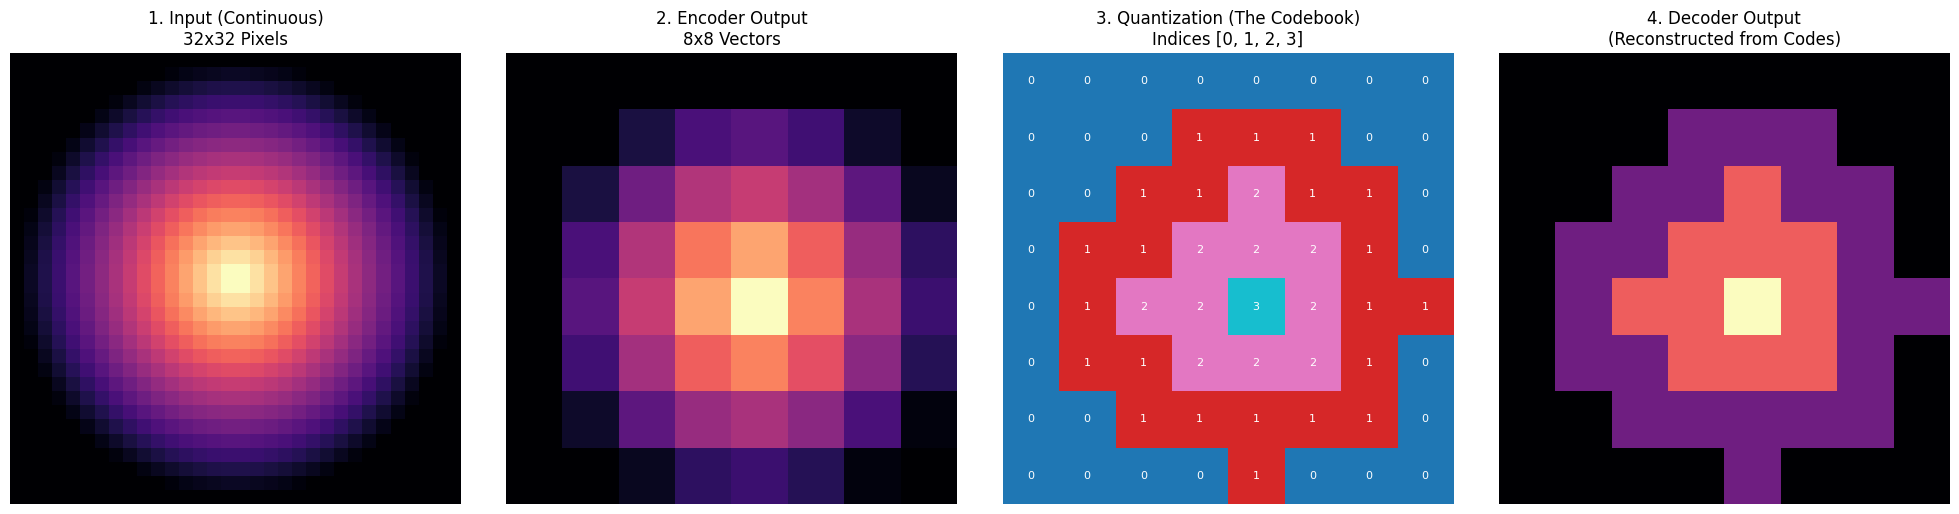

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def generate_vq_vae_diagram():
    # 1. Create a Dummy Input Image (Gradient)
    # A 32x32 image with a gradient and a circle
    x = np.linspace(-1, 1, 32)
    y = np.linspace(-1, 1, 32)
    X, Y = np.meshgrid(x, y)
    input_img = np.sqrt(X**2 + Y**2) # A circle gradient
    input_img = 1 - np.clip(input_img, 0, 1) # Invert so center is bright

    # 2. Simulate Encoder (Downsample)
    # Simply taking every 4th pixel to simulate 4x compression (8x8 grid)
    latent = input_img[::4, ::4]

    # 3. Simulate Quantization (Snap to limited values)
    # We force the values to be one of 4 specific levels (The Codebook)
    levels = np.array([0.0, 0.33, 0.66, 1.0])

    # Find nearest level for each pixel
    quantized = np.zeros_like(latent)
    code_indices = np.zeros_like(latent)

    for i in range(latent.shape[0]):
        for j in range(latent.shape[1]):
            # Find index of nearest level
            idx = (np.abs(levels - latent[i,j])).argmin()
            quantized[i,j] = levels[idx]
            code_indices[i,j] = idx

    # 4. Simulate Decoder (Upsample)
    # Repeat the pixels back to 32x32
    reconstruction = np.repeat(np.repeat(quantized, 4, axis=0), 4, axis=1)

    # --- PLOTTING ---
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Plot Input
    axes[0].imshow(input_img, cmap='magma')
    axes[0].set_title("1. Input (Continuous)\n32x32 Pixels")
    axes[0].axis('off')

    # Plot Latent (The Continuous Encoder Output)
    axes[1].imshow(latent, cmap='magma')
    axes[1].set_title("2. Encoder Output\n8x8 Vectors")
    axes[1].axis('off')

    # Plot Indices (The Codebook IDs)
    # We use a different colormap to show these are DISCRETE categories
    axes[2].imshow(code_indices, cmap='tab10')
    for i in range(8):
        for j in range(8):
            text = axes[2].text(j, i, int(code_indices[i, j]),
                           ha="center", va="center", color="w", fontsize=8)
    axes[2].set_title("3. Quantization (The Codebook)\nIndices [0, 1, 2, 3]")
    axes[2].axis('off')

    # Plot Output
    axes[3].imshow(reconstruction, cmap='magma')
    axes[3].set_title("4. Decoder Output\n(Reconstructed from Codes)")
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

# Run the generator
generate_vq_vae_diagram()

In [ ]:
STEP 1: INPUT IMAGE (4x4)
(Imagine '0.1' is Dark, '0.9' is Bright)
+-----+-----+-----+-----+
| 0.1 | 0.1 | 0.9 | 0.9 |
+-----+-----+-----+-----+
| 0.1 | 0.1 | 0.9 | 0.9 |
+-----+-----+-----+-----+  <-- It looks like a square
| 0.1 | 0.1 | 0.1 | 0.1 |      with a bright top-right.
+-----+-----+-----+-----+
| 0.1 | 0.1 | 0.1 | 0.1 |
+-----+-----+-----+-----+
         |
         v (Encoder compresses it)
         |
STEP 2: LATENT SPACE (2x2)
(The raw vectors before snapping)
+-----------+-----------+
| [0.2,0.1] | [0.8,0.8] |  <-- Top Right is "High Values"
+-----------+-----------+
| [0.2,0.1] | [0.2,0.1] |  <-- Others are "Low Values"
+-----------+-----------+
         |
         v (Vector Quantization: Snap to Codebook)
         v Codebook = { A:[0.1,0.1] (Dark), B:[0.9,0.9] (Bright) }
         |
STEP 3: QUANTIZED CODES (2x2)
(Indices / Discrete Tokens)
+-----------+-----------+
|     A     |     B     |  <-- Snapped to "Dark" and "Bright"
+-----------+-----------+
|     A     |     A     |
+-----------+-----------+
         |
         v (Decoder Reconstructs)
         |
STEP 4: OUTPUT IMAGE (4x4)
+-----+-----+-----+-----+
| 0.1 | 0.1 | 0.9 | 0.9 |
+-----+-----+-----+-----+
| 0.1 | 0.1 | 0.9 | 0.9 |  <-- Reconstructed perfectly
| 0.1 | 0.1 | 0.1 | 0.1 |      because the codes matched!
+-----+-----+-----+-----+
| 0.1 | 0.1 | 0.1 | 0.1 |
+-----+-----+-----+-----+